# Plot results
Plot the gridded fields and the associated error fields.

In [23]:
using Pkg
Pkg.activate(".")
using Glob
using Dates
using ColorSchemes
using NCDatasets
using CairoMakie, GeoMakie
using GeoDatasets
using GeometryOps, GeoInterface
include("./config.jl")
using JupyterFormatter
enable_autoformat()

  Activating project at `~/Projects/EMODnet/EMODnet-Chemistry-GriddedMaps/src`


4-element Vector{Function}:
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)

### Select variable, month and vertical level (depth)
- Water_body_ammonium
- Water_body_chlorophyll-a
- Water_body_dissolved_inorganic_nitrogen
- Water_body_dissolved_oxygen_concentration
- Water_body_phosphate
- Water_body_silicate

In [13]:
varname = "Water_body_dissolved_oxygen_concentration"
varname = "Water_body_phosphate"
depth2plot = 25
month2plot = 5
cmap = cgrad(:RdYlBu, rev = true)
cmaperror = cgrad(:RdYlGn_10, 10, rev = true, categorical = true)

## Files and directories

In [21]:
databasedir = "/home/ctroupin/data/EMODnet-Chemistry/Eutrophication2024/Results/"
datadir = joinpath(databasedir, "../netCDF")
casename = "$(varname)-res-0.25-epsilon2-2.0-varlen1-lb5-maxit-5000-reltol-1.0e-9-bathcl-go-exclude-mL-1960-exNS2-monthly"
resultfile = joinpath(databasedir, casename, "Results/$(varname)_monthly.nc")
isfile(resultfile), isdir(datadir)

(true, true)

## Read fields
### DIVAnd

In [22]:
lon, lat, depth, dates, field, error =
    read_results(resultfile, varname, depth2plot, month2plot);

### WOA fields

In [20]:
if varname == "Water_body_dissolved_oxygen_concentration"
    woavarname = "o"
elseif varname == "Water_body_phosphate"
    woavarname = "p"
end

"p"

In [16]:
woafile = joinpath(woadir, "woa23_all_$(woavarname)$(lpad(month2plot, 2, '0'))_01.nc")
@info("Getting data from $(woafile)")
if isfile(woafile)
    lonwoa, latwoa, depthwoa, dateswoa, fieldwoa, errorwoa =
        read_woa(woafile, varname, depth2plot, lonr, latr)
else
    @warn("$(woafile) does not exist")
end

[ Info: Getting data from /home/ctroupin/data/WOA/woa23_all_p05_01.nc


(Float32[-44.5, -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5, -35.5  …  60.5, 61.5, 62.5, 63.5, 64.5, 65.5, 66.5, 67.5, 68.5, 69.5], Float32[24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5  …  73.5, 74.5, 75.5, 76.5, 77.5, 78.5, 79.5, 80.5, 81.5, 82.5], Float32[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0  …  425.0, 450.0, 475.0, 500.0, 550.0, 600.0, 650.0, 700.0, 750.0, 800.0], [DateTime("1993-05-17T17:56:14.456")], AbstractFloat[0.005961312f0 0.0075269905f0 … NaN NaN; 0.005911928f0 0.008240334f0 … NaN NaN; … ; NaN NaN … 0.5814295f0 0.56596744f0; NaN NaN … 0.5872957f0 0.5663274f0], AbstractFloat[NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN])

## Make the plots
### DIVAnd

In [17]:
f1, ga1, hm1 = plot_field_var(
    varname,
    lon,
    lat,
    field,
    depth2plot,
    month2plot,
    "DIVAnd",
    cmap,
    vmin = 225.0,
    vmax = 375.0,
)
save(joinpath(figdir, "$(varname)_depth-$(depth2plot)_month-$(month2plot)_DIVAnd.png"), f1)

### WOA

In [18]:
f2, ga2, hm2 = plot_field_var(
    varname,
    lonwoa,
    latwoa,
    fieldwoa,
    depth2plot,
    month2plot,
    "WOA",
    cmap,
    vmin = 225.0,
    vmax = 375.0,
)
save(joinpath(figdir, "$(varname)_depth-$(depth2plot)_month-$(month2plot)_WOA.png"), f2)

## Error fields
### DIVAnd

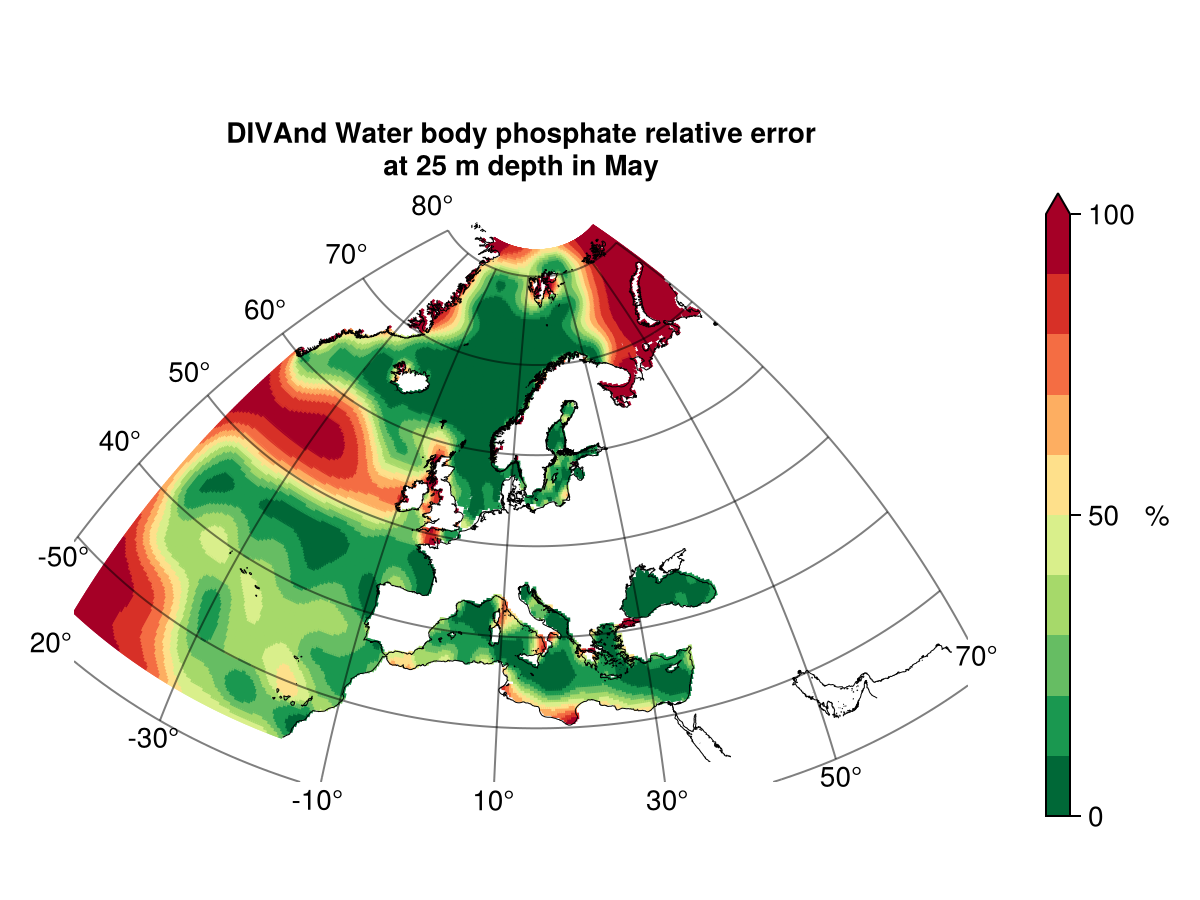

CairoMakie.Screen{IMAGE}


In [30]:
include("./config.jl")
f1, ga1, hm1 = plot_error_field(varname, lon, lat, error, depth2plot, month2plot, "DIVAnd")
display(f1)

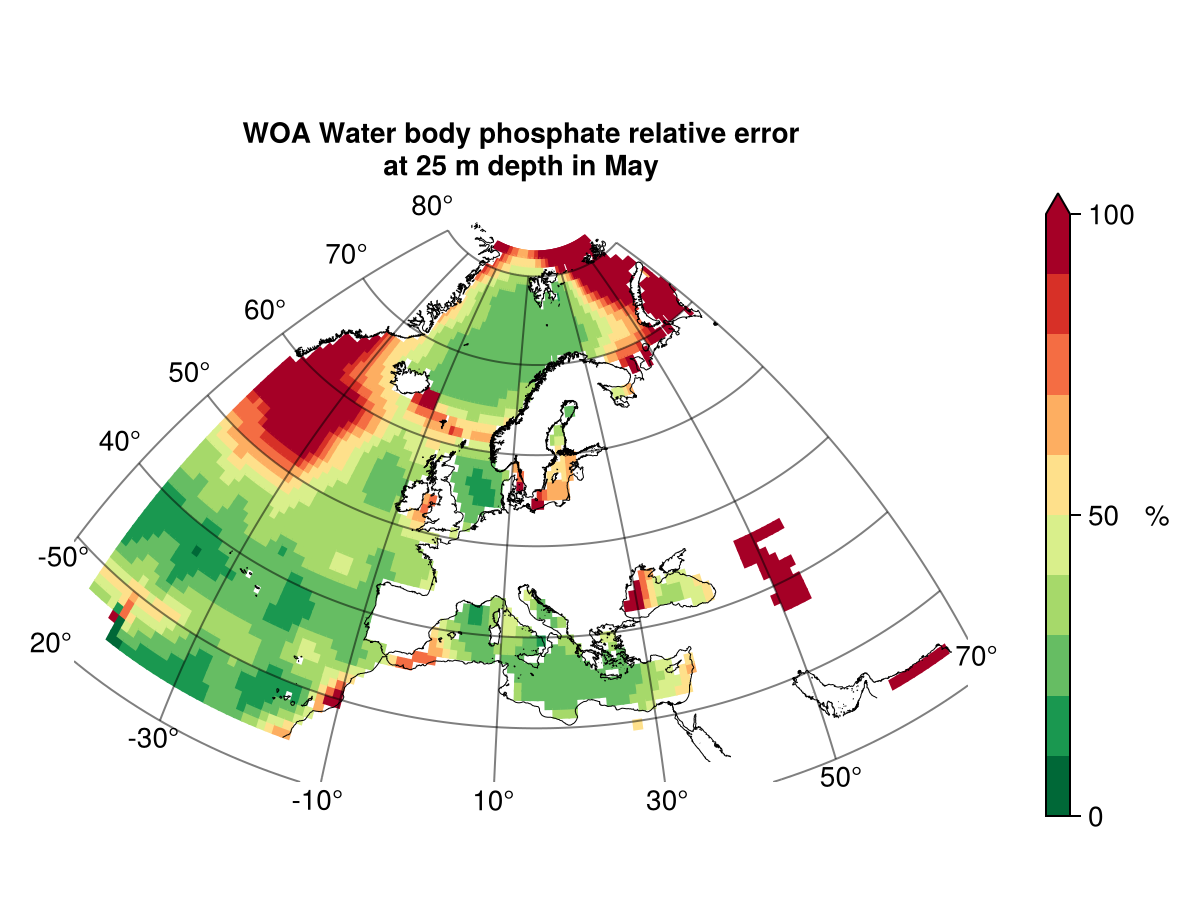

CairoMakie.Screen{IMAGE}


In [33]:
f2, ga2, hm2 =
    plot_error_field(varname, lonwoa, latwoa, errorwoa * 100, depth2plot, month2plot, "WOA")
display(f2)

In [32]:
errorwoa

115×59 Matrix{AbstractFloat}:
 NaN           NaN           NaN           …  NaN         NaN  NaN  NaN
 NaN           NaN           NaN              NaN         NaN  NaN  NaN
 NaN           NaN           NaN              NaN         NaN  NaN  NaN
 NaN           NaN           NaN              NaN         NaN  NaN  NaN
 NaN           NaN             0.0151307      NaN         NaN  NaN  NaN
   0.0           0.0           0.0         …  NaN         NaN  NaN  NaN
   0.0           0.00285111    0.0045241      NaN         NaN  NaN  NaN
   0.00198617    0.00254803    0.003147       NaN         NaN  NaN  NaN
   0.0017448     0.00211164    0.00266722     NaN         NaN  NaN  NaN
   0.00152444    0.00194851    0.00231683     NaN         NaN  NaN  NaN
   0.00160377    0.00192904    0.0023264   …  NaN         NaN  NaN  NaN
   0.00154478    0.00189379    0.0021915      NaN         NaN  NaN  NaN
   0.00153865    0.00181008    0.00211486     NaN         NaN  NaN  NaN
   ⋮                              

## Plot all the annex fields
### Read measurements

In [9]:
resultfile = "/home/ctroupin/data/EMODnet-Chemistry/Eutrophication2024/Results/Monthly/Water_body_phosphate.nc"

"/home/ctroupin/data/EMODnet-Chemistry/Eutrophication2024/Results/Monthly/Water_body_phosphate.nc"

In [10]:
function read_annex_fields(resultfile::String)

    NCDataset(resultfile, "r") do ds
        # print(ds)
        lon = ds["lon"][:]
        lat = ds["lat"][:]
        depth = ds["depth"][:]
        dates = ds["time"][:]

        # Subsetting
        depthindex = findfirst(depth .== depth2plot)
        timeindex = findfirst(Dates.month.(dates) .== month2plot)
        # Read gridded field and error
        field = coalesce.(ds[varname][:, :, depthindex, timeindex], NaN)
        fielderror = coalesce.(ds[varname*"_relerr"][:, :, depthindex, timeindex], NaN)
        fieldL1 = coalesce.(ds[varname*"_L1"][:, :, depthindex, timeindex], NaN)
        fieldL2 = coalesce.(ds[varname*"_L2"][:, :, depthindex, timeindex], NaN)
        fielddeepest = coalesce.(ds[varname*"_deepest"][:, :, timeindex], NaN)

        return lon::Vector{Float64},
        lat::Vector{Float64},
        depth::Vector{Float64},
        dates::Vector{DateTime},
        field::Matrix{AbstractFloat},
        fielderror::Matrix{AbstractFloat},
        fieldL1::Matrix{AbstractFloat},
        fieldL2::Matrix{AbstractFloat},
        fielddeepest::Matrix{AbstractFloat}
    end
end

read_annex_fields (generic function with 1 method)

In [11]:
lon, lat, depth, dates, field, fielderror, fieldL1, fieldL2, fielddeepest =
    read_annex_fields(resultfile);

In [12]:
include("./config.jl")
f3 = plot_additional_field(
    varname,
    varunits[varname],
    lon,
    lat,
    fielddeepest,
    fieldL1,
    fieldL2,
    fielderror,
    depth2plot,
    month2plot,
)
save(
    joinpath(
        figdir,
        "$(varname)_depth-$(depth2plot)_month-$(month2plot)_additional_fields.png",
    ),
    f3,
)

LoadError: LoadError: ArgumentError: Package GeoMakie not found in current path.
- Run `import Pkg; Pkg.add("GeoMakie")` to install the GeoMakie package.
in expression starting at /home/ctroupin/Projects/EMODnet/EMODnet-Chemistry-GriddedMaps/src/config.jl:8